In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 加载数据
news_sentiment = pd.read_csv('data/daily_polarity_news.csv')
btc_price = pd.read_csv('data/BTC-USD.csv')
fear_greed_data = pd.read_csv('data/fear_greed_data.csv')
dxy=pd.read_csv('data/DXY.csv')
sp500=pd.read_csv('data/SP500.csv')
vix=pd.read_csv('data/VIX.csv')

tweets=pd.read_csv('data/2022_tweet_score_final.csv')

# 统一日期格式
news_sentiment['date'] = pd.to_datetime(news_sentiment['date'])
btc_price['time'] = pd.to_datetime(btc_price['time'])
fear_greed_data['timestamp'] = pd.to_datetime(fear_greed_data['timestamp'])
tweets['date'] = pd.to_datetime(tweets['date'])

dxy['time']=pd.to_datetime(dxy['time'])
sp500['time']=pd.to_datetime(sp500['time'])
vix['time']=pd.to_datetime(vix['time'])


# 重命名列名以便合并
news_sentiment.rename(columns={'polarity': 'news_sentiment'}, inplace=True)
btc_price.rename(columns={'time': 'date', 'close': 'btc_close'}, inplace=True)
fear_greed_data.rename(columns={'timestamp': 'date', 'fear_greed': 'fear_greed_index'}, inplace=True)

dxy.rename(columns={'time':'date'},inplace=True)
sp500.rename(columns={'time':'date'},inplace=True)
vix.rename(columns={'time':'date'},inplace=True)



# 只保留需要的列
btc_price = btc_price[['volume','open','date', 'btc_close','SMA_20','RSI_14']]
fear_greed_data = fear_greed_data[['date', 'fear_greed_index']]
tweets=tweets[['date','vader_pos','vader_neu','vader_neg','vader_comp']]

# 合并数据集

merged_data = pd.merge(btc_price, news_sentiment, on='date', how='left')

# 合并贪婪恐惧指数
merged_data = pd.merge(merged_data, fear_greed_data, on='date', how='left')

merged_data=pd.merge(merged_data,dxy,on='date',how='left')
merged_data=pd.merge(merged_data,sp500,on='date',how='left')
merged_data=pd.merge(merged_data,vix,on='date',how='left')

merged_data=pd.merge(merged_data,tweets,on='date',how='left')

# 过滤出2022年的数据
merged_data = merged_data[merged_data['date'].apply(lambda x: x.year == 2022)]


# merged_data.to_csv('merge_data_final.csv')

In [32]:
# Fill missing values for 'news_sentiment' with the mean
merged_data['news_sentiment'].fillna(merged_data['news_sentiment'].mean(), inplace=True)

# For 'dxy_p', 'sp500_p', 'vix_p', you can use forward fill
merged_data[['dxy_p', 'sp500_p', 'vix_p']] = merged_data[['dxy_p', 'sp500_p', 'vix_p']].fillna(method='ffill')

# For 'vader_pos', 'vader_neu', 'vader_neg', 'vader_comp', use linear interpolation
merged_data[['vader_pos', 'vader_neu', 'vader_neg', 'vader_comp']] = merged_data[['vader_pos', 'vader_neu', 'vader_neg', 'vader_comp']].interpolate()

# Check the dataset after filling missing values
merged_data.isnull().sum()

C:\Users\ALLEN AN\AppData\Local\Temp\ipykernel_56104\2652476893.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['news_sentiment'].fillna(merged_data['news_sentiment'].mean(), inplace=True)
C:\Users\ALLEN AN\AppData\Local\Temp\ipykernel_56104\2652476893.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data[['dxy_p', 'sp500_p', 'vix_p']] = merged_data[['dxy_p', 'sp500_p', 'vix_p']].fillna(method='ffill')


volume              0
open                0
date                0
btc_close           0
SMA_20              0
RSI_14              0
Unnamed: 0          4
news_sentiment      0
fear_greed_index    0
dxy_p               1
sp500_p             1
vix_p               1
vader_pos           4
vader_neu           4
vader_neg           4
vader_comp          4
dtype: int64

In [33]:
merged_data.to_csv('data/merge_afterFill.csv')

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas_ta as ta
# 使用 ta-lib 库计算技术指标

cleaned_data=merged_data.dropna()


# 分解比特币收盘价时间序列Time Series Decomposition
result = seasonal_decompose(cleaned_data['btc_close'], model='multiplicative', period=7)

cleaned_data['trend'] = result.trend
cleaned_data['seasonal'] = result.seasonal
cleaned_data['residual'] = result.resid




# 将日期设为索引
cleaned_data.set_index('date', inplace=True)
cleaned_data = cleaned_data.dropna()


C:\Users\ALLEN AN\AppData\Local\Temp\ipykernel_56104\3262213221.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['trend'] = result.trend
C:\Users\ALLEN AN\AppData\Local\Temp\ipykernel_56104\3262213221.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['seasonal'] = result.seasonal
C:\Users\ALLEN AN\AppData\Local\Temp\ipykernel_56104\3262213221.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

btc_close           1.000000
trend               0.997021
open                0.994725
SMA_20              0.971483
sp500_p             0.860515
fear_greed_index    0.306931
vader_neu           0.277277
RSI_14              0.178021
volume              0.151213
residual            0.101389
news_sentiment      0.076644
vader_neg           0.001860
seasonal            0.001711
vix_p              -0.043978
vader_comp         -0.119545
vader_pos          -0.358958
dxy_p              -0.880802
Unnamed: 0         -0.911290
Name: btc_close, dtype: float64


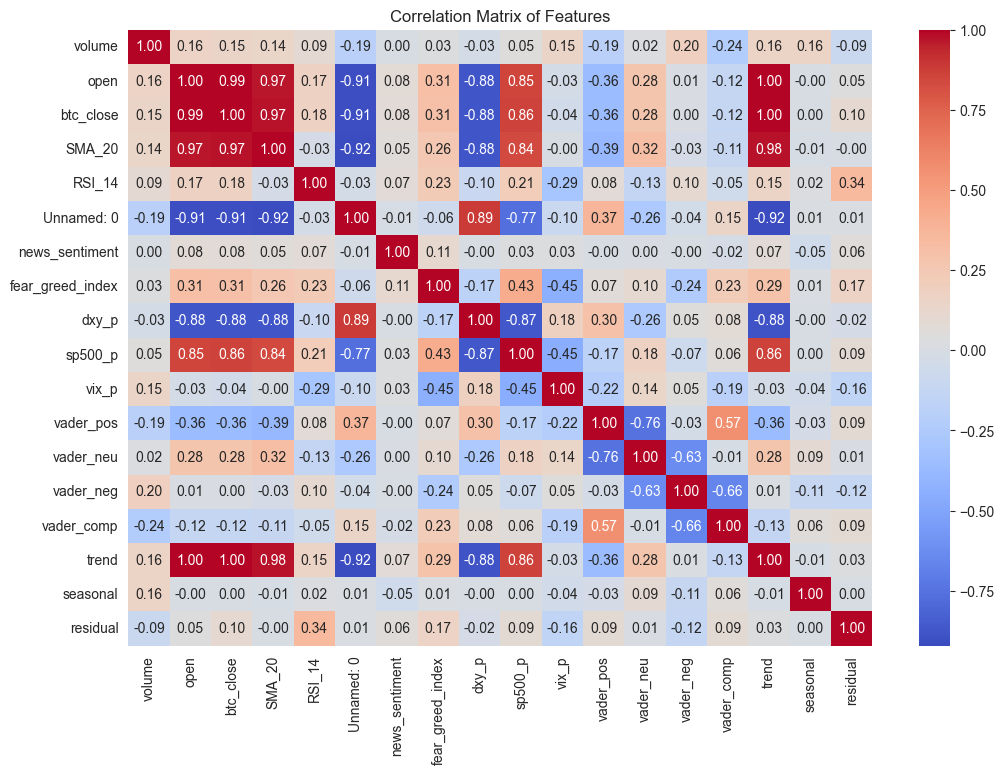

In [35]:
import seaborn as sns

# 只选择数值列
numeric_cols = cleaned_data.select_dtypes(include=['float64', 'int64']).columns

# 计算特征与目标变量的相关性
correlation_matrix = cleaned_data[numeric_cols].corr()
print(correlation_matrix['btc_close'].sort_values(ascending=False))

# 画相关性矩阵的热力图
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()

In [36]:
# 选择特征和目标变量
features = cleaned_data[['btc_close','volume','news_sentiment', 'fear_greed_index','SMA_20','RSI_14','dxy_p','sp500_p','vader_comp','vader_pos','vader_neg']]
target = cleaned_data['btc_close']

In [37]:


# 标准化数据
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))

# 准备训练集和测试集
X = []
y = []

#时间延迟
lag=7

for i in range(lag, len(scaled_features)):
    X.append(scaled_features[i-lag:i])
    y.append(scaled_target[i])

X, y = np.array(X), np.array(y)

# 划分训练集和测试集
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]




In [38]:
import tensorflow as tf
from tensorflow.keras import backend as K

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

In [39]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

In [40]:
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

# 定义模型构建函数，供 Keras Tuner 使用
def build_model(hp):
    model = Sequential()

    # 添加双向LSTM层，允许搜索单元数（50, 100, 150...）
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50), 
                                 return_sequences=True), 
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    
    # 添加Dropout层，允许调整Dropout比例
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))

    # 第二层LSTM
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50), return_sequences=False))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))

    # 添加全连接层
    model.add(Dense(units=hp.Int('dense_units', min_value=10, max_value=100, step=10), activation='relu'))
    model.add(Dense(units=1))  # 输出层

    # 编译模型，允许调整学习率
    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=0.0001, max_value=0.001, step=0.0001))
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=[mae, rmse])

    return model

# 设置 Keras Tuner 的搜索方法
tuner = kt.RandomSearch(
    build_model,                     # 模型构建函数
    objective='val_loss',             # 优化目标是验证集上的损失最小化
    max_trials=10,                    # 尝试10个不同的超参数组合
    executions_per_trial=2,           # 每个超参数组合运行2次
    directory='tuner_logs',           # 保存结果的目录
    project_name='lstm_tuning'        # 项目名称
)

# 打印超参数搜索空间的摘要
tuner.search_space_summary()

# 设置早停和学习率调度
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# 添加 TensorBoard 回调tensorboard --logdir=logs
tensorboard = TensorBoard(log_dir="logs")

# 执行超参数搜索
tuner.search(X_train, y_train, 
             epochs=50, 
             batch_size=32, 
             validation_data=(X_test, y_test), 
             callbacks=[early_stop, reduce_lr, tensorboard])

# 获取最优的超参数组合
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# 输出最优超参数
print(f"Best units: {best_hps.get('units')}")
print(f"Best dropout: {best_hps.get('dropout')}")
print(f"Best dense units: {best_hps.get('dense_units')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")



Reloading Tuner from tuner_logs\lstm_tuning\tuner0.json
Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 10, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.001, 'step': 0.0001, 'sampling': 'linear'}
Best units: 50
Best dropout: 0.4
Best dense units: 70
Best learning rate: 0.0002


In [41]:
# 根据最优的超参数重新构建模型
best_model = tuner.hypermodel.build(best_hps)

# 使用最优模型进行训练
history = best_model.fit(X_train, y_train, 
                         epochs=100, 
                         batch_size=32, 
                         validation_data=(X_test, y_test), 
                         callbacks=[early_stop, reduce_lr, tensorboard])
# 预测
predictions = best_model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

E:\ccy predict\venv\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.1425 - mae: 0.2669 - rmse: 0.3716 - val_loss: 0.3229 - val_mae: 0.5797 - val_rmse: 0.5837 - learning_rate: 2.0000e-04
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0808 - mae: 0.1882 - rmse: 0.2785 - val_loss: 0.1784 - val_mae: 0.4301 - val_rmse: 0.4353 - learning_rate: 2.0000e-04
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0677 - mae: 0.2096 - rmse: 0.2582 - val_loss: 0.0923 - val_mae: 0.3059 - val_rmse: 0.3128 - learning_rate: 2.0000e-04
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0432 - mae: 0.1790 - rmse: 0.2071 - val_loss: 0.0572 - val_mae: 0.2356 - val_rmse: 0.2443 - learning_rate: 2.0000e-04
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0360 - mae: 0.1606 - rmse: 0.1880 - val_loss: 0.0366 - val_mae: 0.1820 - val_rmse: 0.1929 - learning_rate: 2.0000e-04
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0241 - mae: 0.1241 - rmse: 0.1543 - val_loss: 0.0176 - 

In [42]:
best_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 7, 100)         │        24,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 70)             │         3,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,925 (687.21 KB)

 Trainable params: 58,641 (229.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 117,284 (458.14 KB)

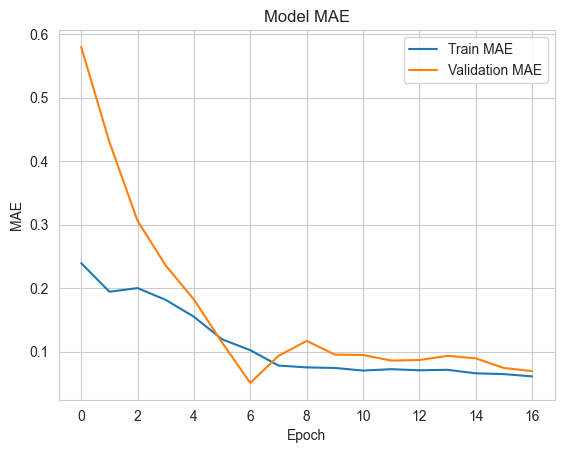

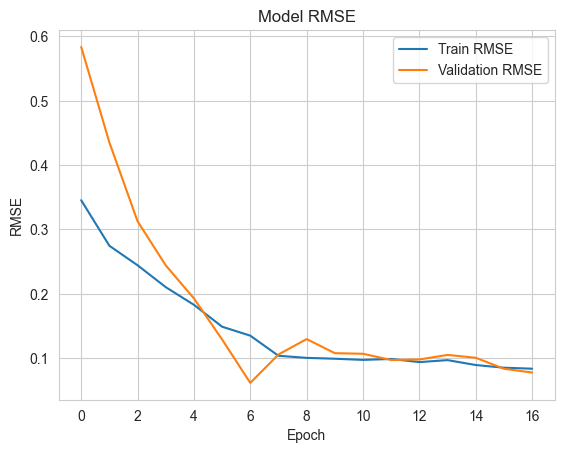

In [43]:
import matplotlib.pyplot as plt

# 绘制 MAE 曲线
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# 绘制 RMSE 曲线
plt.plot(history.history['rmse'], label='Train RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

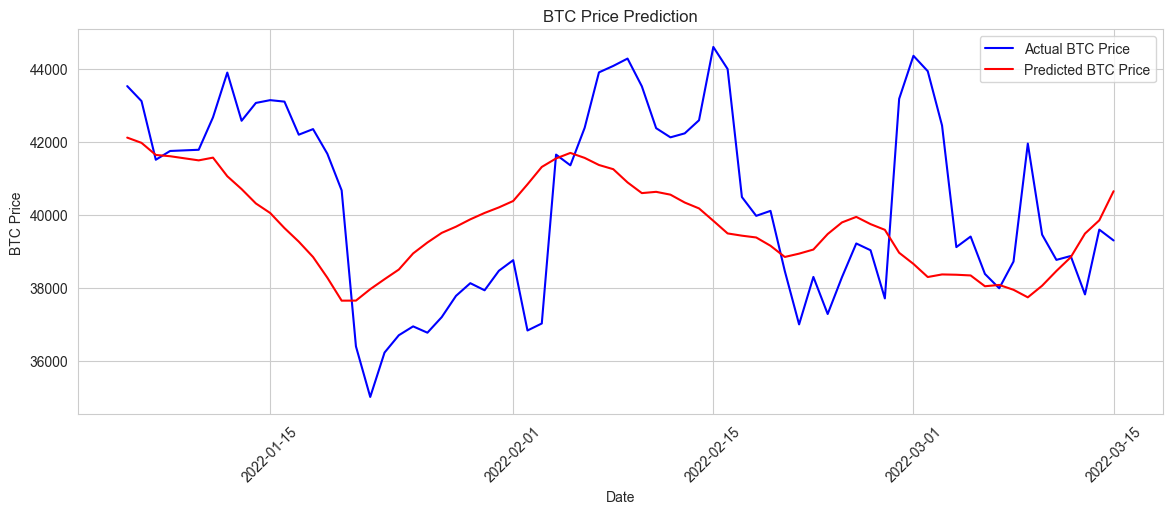

In [44]:
# 反向缩放y_test以进行比较
real_values = scaler.inverse_transform(y_test)
# 获取测试集的日期
test_dates = cleaned_data.index[split + lag:]

# 可视化结果，使用实际日期作为X轴
plt.figure(figsize=(14,5))
plt.plot(test_dates, real_values, color='blue', label='Actual BTC Price')
plt.plot(test_dates, predictions, color='red', label='Predicted BTC Price')
plt.title('BTC Price Prediction')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 计算MSE, RMSE和MAE
mse = mean_squared_error(real_values, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(real_values, predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

MSE: 5916524.984979957
RMSE: 2432.3907961057484
MAE: 1995.6721168101515
